In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import scipy.stats as stats
from scipy.stats import norm
import datetime as dt

In [326]:
amd = pd.read_csv('AMD_5YR.csv')
amd.head()
amd.tail()
#5 year data from 6/3/2019 to 5/31/24

,Date,Close/Last,Volume,Open,High,Low
1254,06/07/2019,$32.41,86841100,$31.94,$32.60,$31.57
1255,06/06/2019,$31.82,131267800,$29.87,$31.98,$29.84
1256,06/05/2019,$29.50,79481540,$29.93,$29.99,$29.03
1257,06/04/2019,$29.57,107549500,$28.39,$29.59,$27.91
1258,06/03/2019,$27.58,147532200,$28.75,$29.62,$27.29


In [327]:
#renaming the close/last column to just close
amd = amd.rename(columns = {'Close/Last':'Close'})
amd.head()
print(amd.dtypes)

Date      object
Close     object
Volume     int64
Open      object
High      object
Low       object
dtype: object


In [328]:
#I need to change the date to datetime and the objects to float
#To convert to float, we remove the dollar sign 
amd[['Close', 'Open', 'High', 'Low']] = amd[['Close', 'Open', 'High', 'Low']].replace('[\$,]', '', regex=True).astype(float)
print(amd.dtypes)

Date       object
Close     float64
Volume      int64
Open      float64
High      float64
Low       float64
dtype: object


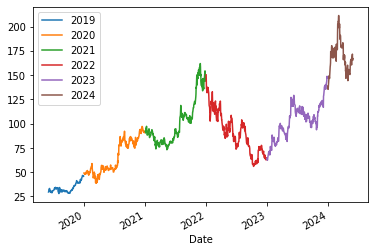

In [329]:
#I want to have a price diff column on this dataset
amd['PriceDiff'] = amd['Close'].shift(-1) - amd['Close']
amd['DailyReturn'] = amd['PriceDiff']/amd['Close']
amd.dropna(inplace=True)
# Convert 'Date' column to datetime
amd['Date'] = pd.to_datetime(amd['Date'])  
amd.set_index('Date', inplace=True)
#Data needs sorting
amd.sort_values(by='Date', inplace=True)
#Line graph of the closing data 2019-2024 
amd.loc['01-01-2019':'12-31-2019', 'Close'].plot(label='2019')#2019
amd.loc['01-01-2020':'12-31-2020', 'Close'].plot(label='2020') #2020
amd.loc['01-01-2021':'12-31-2021', 'Close'].plot(label='2021') #2021
amd.loc['01-01-2022':'12-31-2022', 'Close'].plot(label='2022') #2022
amd.loc['01-01-2023':'12-31-2023', 'Close'].plot(label='2023') #2023
amd.loc['01-01-2024':'12-31-2024', 'Close'].plot(label='2024') #2024
plt.legend()



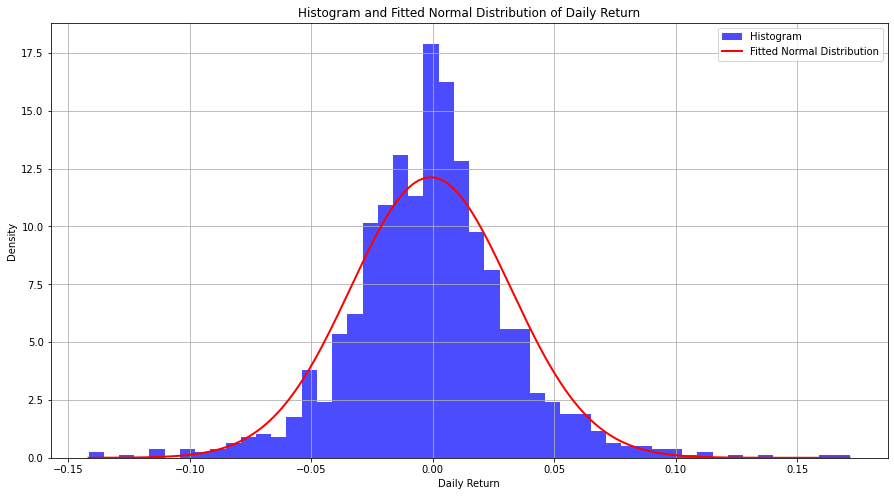

In [330]:
#fitting a normal distribution on the daily returns
mu, sigma = stats.norm.fit(amd['DailyReturn'])

plt.figure(figsize=(15, 8))
plt.hist(amd['DailyReturn'], bins=50, density=True, alpha=0.7, color='blue', label='Histogram')

x = np.linspace(amd['DailyReturn'].min(), amd['DailyReturn'].max(), 1000)
#probability density function (PDF) values
pdf = stats.norm.pdf(x, mu, sigma)

# Plot the fitted normal distribution
plt.plot(x, pdf, 'r-', lw=2, label='Fitted Normal Distribution')

plt.title('Histogram and Fitted Normal Distribution of Daily Return')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
#looks great and fits normal

C:\Users\leoju\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\leoju\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


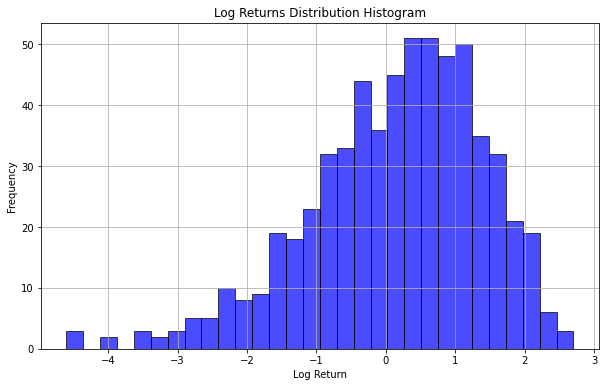

In [331]:
#I am exploring the log of the daily returns and see the nature of this
amd['LogReturn'] = np.log(amd['PriceDiff'])
amd.dropna(inplace=True)
amd.head()

log_return = amd['LogReturn'][np.isfinite(amd['LogReturn'])]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(log_return, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Log Returns Distribution Histogram')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

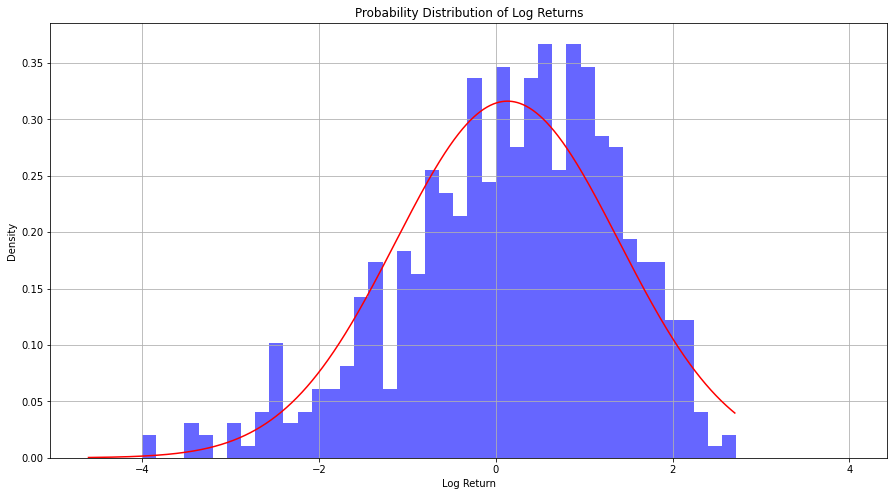

In [332]:

#there are values that are infinite. Filter them out to see the distribtuion

log_return = amd['LogReturn'][np.isfinite(amd['LogReturn'])]

# Calculate mean and standard deviation for LogReturn
mu = log_return.mean()
sigma = log_return.std(ddof=1)

# Create density DataFrame for PDF
density = pd.DataFrame()
density['X'] = np.linspace(log_return.min(), log_return.max(), 1000)  
density['PDF'] = norm.pdf(density['X'], mu, sigma)

# Plot histogram with PDF
plt.figure(figsize=(15, 8))
log_return.hist(bins=50, density=True, alpha=0.6, color= 'blue', range = (-4, 4))  
plt.plot(density['X'], density['PDF'], color='red')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.title('Probability Distribution of Log Returns')
plt.grid(True)
plt.show()

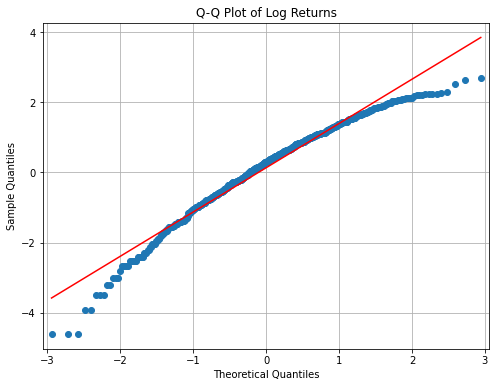

In [333]:
#I need to assess the goodness of fit
#First a qq plot

import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(log_return, line='s', ax=ax) 
plt.title('Q-Q Plot of Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()
#close to getting this to a normal distribution but I think the norm of daily returns is already a great fit

In [334]:
#the pricediff fits the lognorm distribution
#I will calculate the VaR and will use historical simulation to estimate Var and CVaR at different confidence intervals.
mu = amd['DailyReturn'].mean()
sigma = amd['DailyReturn'].std(ddof=1)
prob_return = norm.cdf(-0.05, mu, sigma)
print(prob_return)
#probability that the AMD drops over 5% in a day is around 6.8%

0.00076811612073169


In [335]:
#I want to explore what some other scenerios.
mu220 = 220*mu
sigma220 = (220**.05) * sigma
prob_dropping_20percent = stats.norm.cdf(-0.2, mu220, sigma220)
print(prob_dropping_20percent)
#AMD has a 45.80% chance of dropping more that 20%. 

0.0


In [336]:
VaR = norm.ppf(.05, mu, sigma)
print('Single Day Value At Risk: ', VaR)

Single Day Value At Risk:  -0.014652866404780161


Value at Risk (VaR): 1.1342269157792289
Conditional Value at Risk (CVaR): 1.1004438712453644


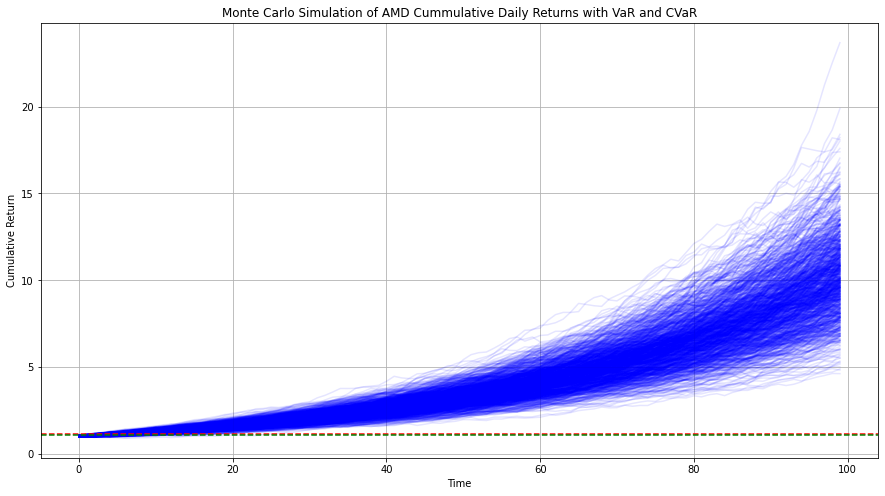

In [337]:
#Monte Carlo simulation for the AMD Daily Returns
#mu and sigma is already calculated 
mc_sims = 1000
T = 100

simulated_returns = np.zeros((mc_sims, T))

for i in range(mc_sims): 
    rand_returns = np.random.normal(mu, sigma, T)   
    simulated_returns[i] = np.cumprod(1 + rand_returns)

simulated_returns_df = pd.DataFrame(simulated_returns)

def mcVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError('Expected a pandas data series.')

def mcCVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        belowVar = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVar].mean()
    else:
        raise TypeError('Expected a pandas data series.')
        
#slice the last row of the simulation

portResults = pd.Series(simulated_returns_df.iloc[-1])

VaR = mcVaR(portResults, alpha=5)
CVaR = mcCVaR(portResults, alpha=5)

print("Value at Risk (VaR):", VaR)
print("Conditional Value at Risk (CVaR):", CVaR)

# Plot simulated returns with the VaR line and CVaR line
plt.figure(figsize=(15, 8))
for i in range(mc_sims):
    plt.plot(simulated_returns_df.iloc[i], color='blue', alpha=0.1)  
plt.axhline(y=VaR, color='red', linestyle='--', label='VaR')
plt.axhline(y=CVaR, color='green', linestyle='--', label='CVaR')
plt.title('Monte Carlo Simulation of AMD Cummulative Daily Returns with VaR and CVaR')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()


            Close    Volume   Open   High    Low  PriceDiff  DailyReturn  \
Date                                                                       
2019-06-05  29.50  79481540  29.93  29.99  29.03       0.07     0.002373   
2019-06-11  32.41  82834910  33.43  33.49  31.82       0.82     0.025301   
2019-06-12  32.18  56298670  32.00  32.57  31.92       0.23     0.007147   
2019-06-13  31.39  63555990  32.39  32.50  31.06       0.79     0.025167   
2019-06-14  30.36  70373020  30.70  30.96  30.02       1.03     0.033926   

            LogReturn  
Date                   
2019-06-05  -2.659260  
2019-06-11  -0.198451  
2019-06-12  -1.469676  
2019-06-13  -0.235722  
2019-06-14   0.029559  


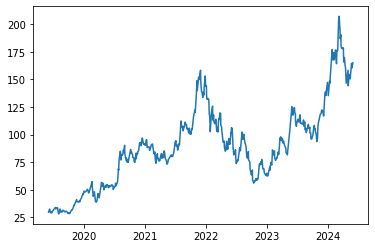

In [409]:
#Forecasting
#Analyzing the close price trend again
plt.plot(amd.index, amd['Close'])
start = dt.datetime(2019, 6, 3)
end = dt.datetime(2022, 6, 3)

training_data = amd.loc[start:end]
print(training_data.head())

In [410]:
#preparing my data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(training_data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [411]:
#model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)
          

Epoch 1/25
10/10 [==============================] - 4s 42ms/step - loss: 0.0728
Epoch 2/25
10/10 [==============================] - 0s 41ms/step - loss: 0.0194
Epoch 3/25
10/10 [==============================] - 0s 41ms/step - loss: 0.0131
Epoch 4/25
10/10 [==============================] - 0s 41ms/step - loss: 0.0108
Epoch 5/25
10/10 [==============================] - 0s 44ms/step - loss: 0.0103
Epoch 6/25
10/10 [==============================] - 0s 43ms/step - loss: 0.0096
Epoch 7/25
10/10 [==============================] - 0s 43ms/step - loss: 0.0091
Epoch 8/25
10/10 [==============================] - 0s 43ms/step - loss: 0.0074
Epoch 9/25
10/10 [==============================] - 0s 41ms/step - loss: 0.0087
Epoch 10/25
10/10 [==============================] - 0s 41ms/step - loss: 0.0086
Epoch 11/25
10/10 [==============================] - 0s 43ms/step - loss: 0.0075
Epoch 12/25
10/10 [==============================] - 0s 41ms/step - loss: 0.0089
Epoch 13/25
10/10 [==================

In [412]:
#testing the model accuracy on existing data

test_start = dt.datetime(2022, 6, 4)
test_end = dt.datetime(2024, 5, 30)

test_data = amd.loc[test_start:test_end, 'Close']
actual_prices = amd['Close'].values

total_dataset = pd.concat((amd['Close'], test_data), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


In [413]:
#prediction with test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
if len(x_test.shape) == 2:
    x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)



8/8 [==============================] - 1s 14ms/step


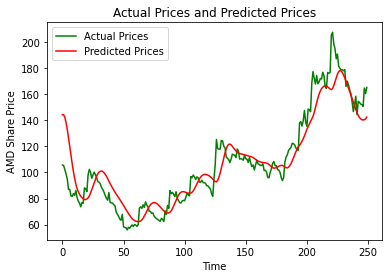

In [414]:
plt.plot(actual_prices_for_plot, color="green", label="Actual Prices")

# Plot the predicted prices
plt.plot(predicted_prices, color="red", label="Predicted Prices")

plt.title("Actual Prices and Predicted Prices")
plt.xlabel('Time')
plt.ylabel('AMD Share Price')
plt.legend()
plt.show()

In [415]:
#predicting next day

real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)
                          

1/1 [==============================] - 0s 26ms/step
[[144.1544]]


In [ ]:
#next day 6/1/24 predicted 144.15
